## Import necessary libraries

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load the datasets

In [2]:
train_file = '/kaggle/input/poker-hand-dataset/poker-hand-training.data'
test_file = '/kaggle/input/poker-hand-dataset/poker-hand-testing.data'

### Data Cleaning Process

In [3]:
columns = ['first_suit', 'first_rank', 'second_suit', 'second_rank', 'third_suit', 'third_rank',
           'fourth_suit', 'fourth_rank', 'fifth_suit', 'fifth_rank', 'hand']

hand_mapping = {
    0: 'zilch',
    1: 'one_pair',
    2: 'two_pair',
    3: 'three_of_a_kind',
    4: 'straight',
    5: 'flush',
    6: 'full_house',
    7: 'four_of_a_kind',
    8: 'straight_flush',
    9: 'royal_flush'
}

In [4]:
train_data = pd.read_csv(train_file, header=None, names=columns)
test_data = pd.read_csv(test_file, header=None, names=columns)

In [5]:
train_data

,first_suit,first_rank,second_suit,second_rank,third_suit,third_rank,fourth_suit,fourth_rank,fifth_suit,fifth_rank,hand
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9
...,...,...,...,...,...,...,...,...,...,...,...
25005,3,9,2,6,4,11,4,12,2,4,0
25006,4,1,4,10,3,13,3,4,1,10,1
25007,2,1,2,10,4,4,4,1,4,13,1
25008,2,12,4,3,1,10,1,12,4,9,1


In [6]:
test_data

,first_suit,first_rank,second_suit,second_rank,third_suit,third_rank,fourth_suit,fourth_rank,fifth_suit,fifth_rank,hand
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0
...,...,...,...,...,...,...,...,...,...,...,...
999995,3,1,1,12,2,9,4,9,2,6,1
999996,3,3,4,5,2,7,1,4,4,3,1
999997,1,11,4,7,3,9,1,13,2,7,1
999998,3,11,1,8,1,1,3,13,2,8,1


## Data Preparation

In [7]:
# Apply the mapping to the target variable
y_train = train_data['hand']
y_test = test_data['hand']

# Separate features
X_train = train_data.drop('hand', axis=1)
X_test = test_data.drop('hand', axis=1)

In [8]:
# Assuming 'X' (features) and 'y' (labels) are already defined
def preprocess_data(X, y):
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

In [9]:
# Preprocess the data
X_train_preprocessed, y_train_preprocessed = preprocess_data(X_train, y_train)
X_test_preprocessed, y_test_preprocessed = preprocess_data(X_test, y_test)

In [10]:
# Define a function to train and evaluate models
def train_and_evaluate_model(model, param_grid=None):
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_preprocessed, y_train_preprocessed)
        model = grid_search.best_estimator_
    else:
        model.fit(X_train_preprocessed, y_train_preprocessed)

    y_pred = model.predict(X_test_preprocessed)
    accuracy = accuracy_score(y_test_preprocessed, y_pred)
    print(f"Test Accuracy for {model.__class__.__name__}: {accuracy:.4f}")

    # Calculate ROC Curve and AUC
    y_pred_prob = model.predict_proba(X_test_preprocessed)
    fpr, tpr, _ = roc_curve(y_test_preprocessed, y_pred_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    return accuracy, fpr, tpr, roc_auc

## Train Model

In [11]:
print("Starting Model Training and Evaluation...\n")

# MLP Classifier
print("Training MLP Classifier...")
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu','tanh'],
    'solver': ['adam'],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.0001, 0.001]
}
mlp_model = MLPClassifier(random_state=42, max_iter=2000)
mlp_accuracy, mlp_fpr, mlp_tpr, mlp_roc_auc = train_and_evaluate_model(mlp_model, param_grid=mlp_params)
print("\n")

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42, k_neighbors=4)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train_preprocessed)

# Random Forest Classifier
print("Training Random Forest Classifier...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'class_weight': ['balanced', None]
}
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)
rf_accuracy, rf_fpr, rf_tpr, rf_roc_auc = train_and_evaluate_model(RandomForestClassifier(random_state=42), param_grid=rf_params)
print("\n")

# Gradient Boosting Classifier
print("Training Gradient Boosting Classifier...")
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_model = GradientBoostingClassifier(random_state=42)
gb_accuracy, gb_fpr, gb_tpr, gb_roc_auc = train_and_evaluate_model(gb_model, param_grid=gb_params)
print("\n")

Starting Model Training and Evaluation...

Training MLP Classifier...
Test Accuracy for MLPClassifier: 0.9924


Training Random Forest Classifier...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Test Accuracy for RandomForestClassifier: 0.6190


Training Gradient Boosting Classifier...
Test Accuracy for GradientBoostingClassifier: 0.3204




## Test Model

In [12]:
base_models = [
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

meta_model = RandomForestClassifier(random_state=42)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, n_jobs=1)

stacking_model.fit(X_train_preprocessed, y_train_preprocessed)

stacking_pred = stacking_model.predict(X_test_preprocessed)
stacking_accuracy = accuracy_score(y_test_preprocessed, stacking_pred)
stacking_pred_prob = stacking_model.predict_proba(X_test_preprocessed)
stacking_fpr, stacking_tpr, _ = roc_curve(y_test_preprocessed, stacking_pred_prob[:, 1], pos_label=1)
stacking_roc_auc = auc(stacking_fpr, stacking_tpr)

print(f"Test Accuracy: {stacking_accuracy:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_preprocessed, stacking_pred, zero_division=0)}")

Test Accuracy: 0.9382

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    501209
           1       0.96      0.93      0.95    422498
           2       0.91      0.50      0.65     47622
           3       0.64      0.90      0.75     21121
           4       0.00      0.00      0.00      3885
           5       0.95      0.67      0.79      1996
           6       0.12      0.01      0.02      1424
           7       0.03      0.00      0.01       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.94   1000000
   macro avg       0.46      0.40      0.41   1000000
weighted avg       0.94      0.94      0.93   1000000



## Visualizing Model Evaluation Metrics

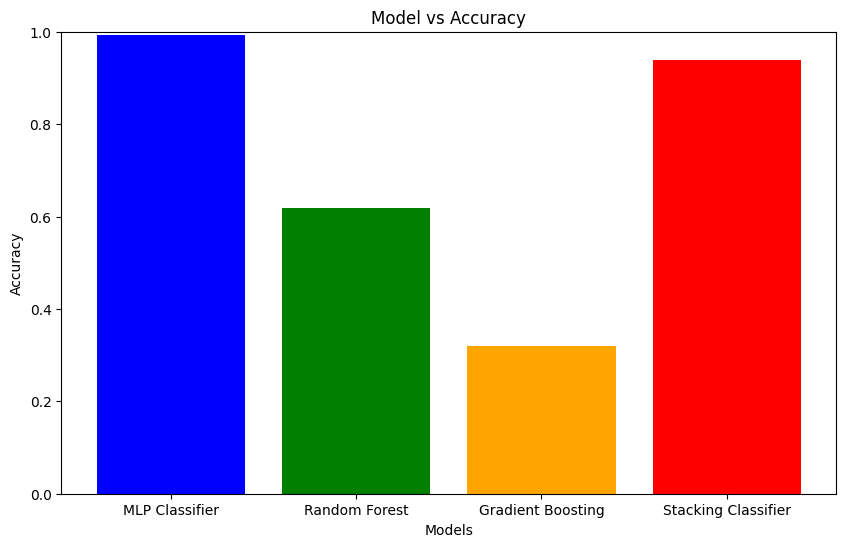

In [13]:
# Plot Model vs Accuracy Bar Graph
model_names = ['MLP Classifier', 'Random Forest', 'Gradient Boosting', 'Stacking Classifier']
accuracies = [mlp_accuracy, rf_accuracy, gb_accuracy, stacking_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model vs Accuracy')
plt.ylim(0, 1)
plt.show()

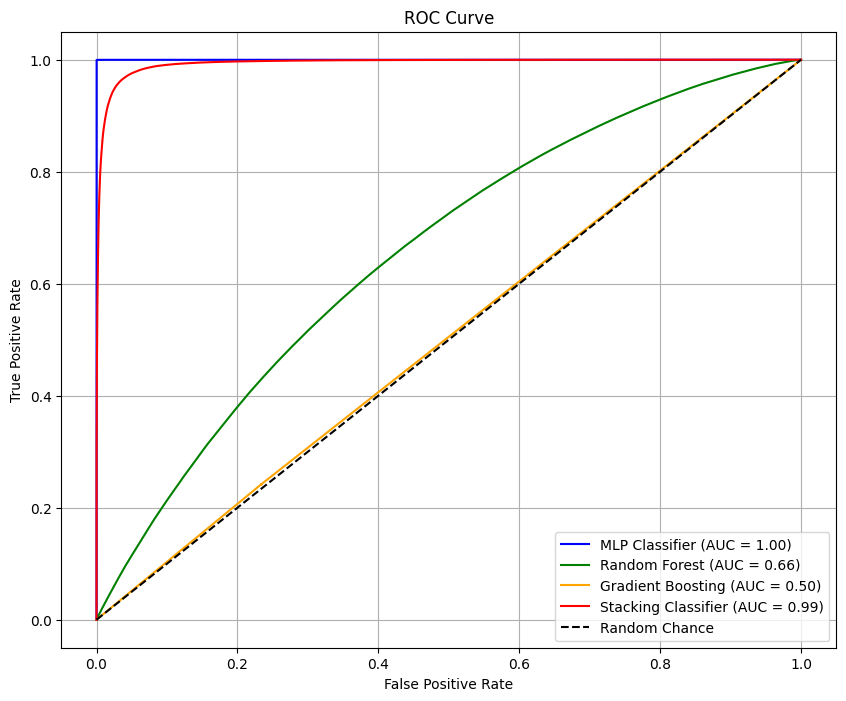

In [14]:
# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(mlp_fpr, mlp_tpr, label=f"MLP Classifier (AUC = {mlp_roc_auc:.2f})", color='blue')
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_roc_auc:.2f})", color='green')
plt.plot(gb_fpr, gb_tpr, label=f"Gradient Boosting (AUC = {gb_roc_auc:.2f})", color='orange')
plt.plot(stacking_fpr, stacking_tpr, label=f"Stacking Classifier (AUC = {stacking_roc_auc:.2f})", color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

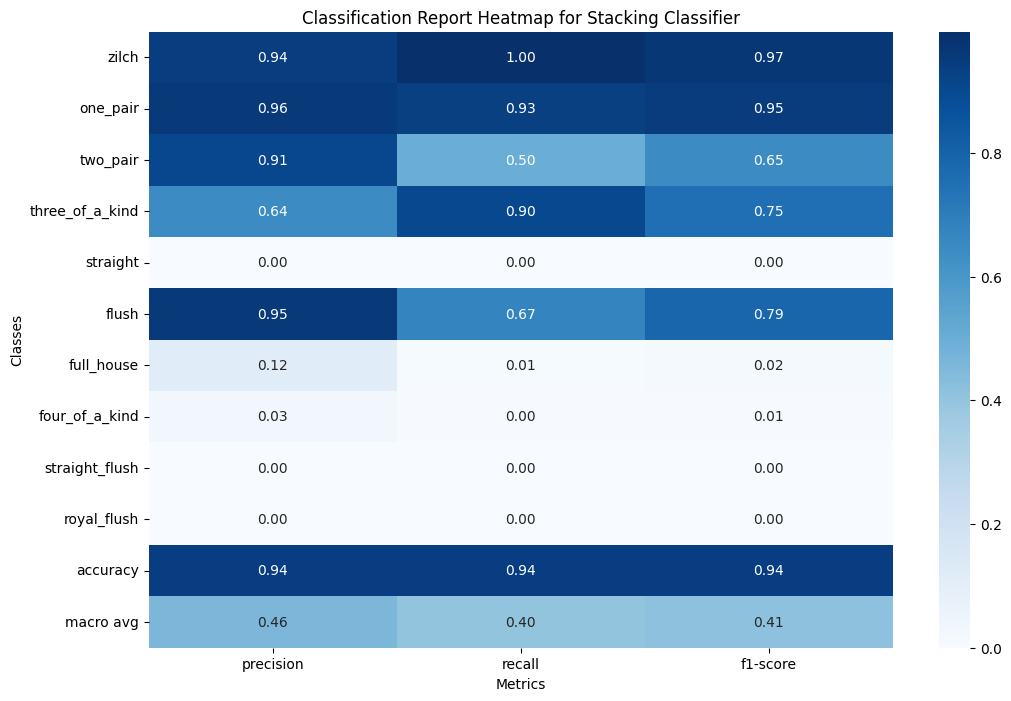

In [15]:
# Classification Report Heatmap for Stacking Classifier
classification_report_dict = classification_report(y_test_preprocessed, stacking_pred, target_names=[hand_mapping[i] for i in range(10)], output_dict=True, zero_division=0)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(classification_report_dict).transpose()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap for Stacking Classifier")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()